In [5]:
import numpy as np
import torch #framework
import torch.nn.functional as F
import matplotlib.pyplot as plt
from time import time 
from torchvision import datasets, transforms
from torch import nn, optim

In [12]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()




11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
import torch.utils.data.dataloader

transform= transforms.ToTensor() #definindo conversão de imagens para tensor
trainset = datasets.MNIST('./MNIST_data', download = True, train=True, transform= transform)  #carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data', download=True, train=False, transform=transform) #carrega a parte de validação
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes


#https://yann.lecun.com/exdb/mnist/


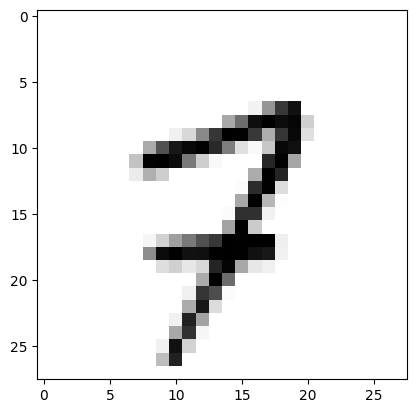

In [8]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')

In [9]:
print(imagens[0].shape) #para verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) #para verificar as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [10]:
# https://keras.io/api/applications/#usage-examples-for-image-classification-models
#https://github.com/keras-team/keras/blob/v3.7.0/keras/src/applications/inception_v3.py#L19

#Estruturação da rede

class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) #camada de entrada, 784 neurônios se ligam a 128
        self.linear2 = nn.Linear (128, 64) # camada interna 1, 128 neurônios se ligam a 64
        self.Linear3 = nn.Linear(64,10) #camada interna 2, 64 neurônios se ligam a 10
        #para a cama de saída não é necessário definir nada pois só precisamos pegar o output da camada 2

    def foward(self,X):
        X= F.relu(self.linear1(X)) #função de ativação camada de entrada para camada interna 1
        X= F.relu(self.linear2(X)) #função de ativação da camada interna 1 para a camada interna 2
        X = self.Linear3(X) #função de ativação da camada 2 para a camada de saída, nesse caso f(x) = x
        return F.log_softmax(X, dim=1) #dados utilizados para calcular a perda 

In [12]:
#Otimizador da rede

def treino(modelo, trainloader, device):
    otimizador = optim.SGD(modelo.parameters(), lr=0, momentum=0.5) #define a política de atualização dos pesos e da bias
    inicio = time()

    criterio = nn.NLLLoss() #definindo o critério para calcular a perda 
    EPOCHS = 10 #número de epoch que o algoritmo rodará
    modelo.train() 

    for epoch in range (EPOCHS):
        perda_acumulada = 0

        for imagens, etiquetas in trainloader:
            imagens= imagens.view(imagens.shape[0], -1) #convertendo as imagens de "vetores" de 28*28 casas para 
            otimizador.zero_grad() #zerando os gradientes por conta do ciclo anterior

            output = modelo(imagens.to(device)) #colocando os dados no modelo 
            perda_instantanea= criterio(output, etiquetas.to(device)) #calculando a perda da epochem questão

            perda_instantanea.backward()  #back propagation a partir de agora

            otimizador.step() # atualizando os pesos e as bias 

            perda_acumulada += perda_instantanea.item() #Atualização da perda acumulada


        else: print("EPOCH {}- Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
        print("\n Tempo de treino (em minutos)", time()-inicio/60)

In [13]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    for imagens, etiquetas in valloader:
        for i in range (len(etiquetas)):
            img = imagens[i].view(1,784)
            with torch.no_grad:
                logps = modelo(img.to(device))

            ps = torch.exp(logps)
            probab = list(ps.cpu().numpy()[0])
            etiqueta_pred = probab.index(max(probab))
            etiqueta_certa= etiquetas.numpy()[i]
            if(etiqueta_certa == etiqueta_pred):
                conta_corretas +=1 
                conta_todas +=1 

    print("Total de imagens testadas=", conta_todas)
    print("\n Precisão do modelo = {}%".format(conta_corretas*100/conta_todas))

In [14]:
modelo = Modelo()

device = torch.device("cuda"if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (Linear3): Linear(in_features=64, out_features=10, bias=True)
)